# Constellation Mission Planning Tool
This notebook tutorial shows how to fly a constellation of satellites through model data, focusing on spherical coordinate examples as an introduction. Trajectories can be obtained either from the test GDC trajectory file or the flythrough trajectory functions as shown here. See the Satellite Trajectory section for examples on trajectory options, and the Choosing Models and Variables section for more information on choosing models and variables. This functionality is not available from the command line. More complex workflow examples are included in the notebooks directory on the main level.

## Preparing to run

In [1]:
# For a given model, find out what time range is covered by the data in a given directory.
from kamodo_ccmc.flythrough import model_wrapper as MW
import datetime as dt
model, file_dir = 'GITM', 'D:/GITM/jasoon_shim_071418_IT_1_tenth_oneday/'  # change to match your machine
start_utcts = dt.datetime(2015, 3, 17, 0).replace(tzinfo=dt.timezone.utc).timestamp()
end_utcts = dt.datetime(2015, 3, 17, 6).replace(tzinfo=dt.timezone.utc).timestamp()-1
# This function also automatically performs any data preparation needed.

In [2]:
# Import function to retrieve the grace1 trajectory from the SSCWeb.
from kamodo_ccmc.flythrough import SatelliteFlythrough as SF
# Typical coordinates possible through SSCWeb are GEO, GSE, SM, and GSM (all cartesian and in R_E).
input_coord = 'GEO'
traj_dict, coord_type = SF.SatelliteTrajectory('grace1', start_utcts, end_utcts, coord_type=input_coord)

C:\Users\rringuet\Anaconda3\envs\Kamodo_Jan2023\lib\site-packages\spacepy\time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


Attribute/Key names of return dictionary: dict_keys(['sat_time', 'c1', 'c2', 'c3'])


In [3]:
# Convert coordinates to system desired for reconstruction to take place in.
# The trajectories were retrieved in GEO cartesian, and are converted to GEO spherical below.
from kamodo_ccmc.flythrough.utils import ConvertCoord
c1, c2, c3, units = ConvertCoord(traj_dict['sat_time'], traj_dict['c1'], traj_dict['c2'], traj_dict['c3'],
                                 input_coord, 'car', input_coord, 'sph')
print(c1.min(), c1.max(), c2.min(), c2.max(), c3.min(), c3.max())

-177.97713698151003 170.68868826059744 -88.76818132167068 88.97299240106359 1.0600288778760936 1.0644534136698656


In [4]:
# Choose a variable from the model data chosen.
MW.Variable_Search('', model, file_dir)


The file directory contains the following standardized variable names:
-----------------------------------------------------------------------------------
rho_N2 : '['mass density of molecular nitrogen', 13, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_N2plus : '['mass density of molecular nitrogen ion', 14, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_NO : '['mass density of nitric oxide', 20, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_NOplus : '['mass density of nitric oxide ion', 21, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_O2 : '['mass density of molecular oxygen', 22, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_O2plus : '['mass density of molecular oxygen ion', 24, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_O3P : '['mass density of atomic oxygen (3P state)', 27, 'GDZ', 'sph', ['time', 'lon', 'lat', 'height'], 'kg/m**3']'
rho_Oplus4S4P : '['mass density of ato

In [5]:
# Bring up documentation for the reconstruction functionality.
from kamodo_ccmc.flythrough.Reconstruction_v0 import RECON
RECON.__doc__.split('\n')

['Uses shifted copies of the satellite trajectory to reconstruct ',
 '    the model data for the variable name given.',
 '    ',
 "    - model: 'CTIPe', 'IRI', 'GITM', 'SWMF_IE', 'TIEGCM'",
 '    - variable_name = choose from list of standardized variable names from model chosen',
 '    - file_dir = file path to model data',
 '    - sat_time: a numpy array of the utc timestamps',
 '    - c1, c2, c3: numpy arrays of the positions correlating to the utc timestamps',
 '        (c1, c2, c3) should be (x,y,z) in R_E for cartesian coordinates, and (lon, lat, ',
 '        radius (R_E) or altitude (km)) for spherical coordinates. ',
 "    - coord_type: one of 'GDZ', 'GEO', 'GSM', 'GSE', 'SM', 'GEI', 'MAG', 'SPH', 'RLL'",
 "    - coord_grid: either 'car' or 'sph'. Note that not all combinations ",
 "        make sense (e.g. 'SPH' and 'car') and are not allowed.   ",
 '        Note that GDZ sph is the only coordinate system that assumes the third coordinate',
 '        is an altitude and is in k

In [6]:
# Choose inputs.
variable_name = 'rho_n'  # from chosen files above
recon_dimensions = 'c1c2'  # Longitude vs Latitude reconstruction for spherical coordinates
recon_option = 'UnMod_AvgDSlice'
# fly the given trajectory through the data unmodified, then fly the reconstructed coordinate grid through the data
# after taking the average of t and height.

# Set up constellation input:
lon_offsets = [0., 30., 60., 90., 120., 150.]  # 6 satellites equally spaced in longitude

# Choose the grid resolution of reconstruction. The finer the resolution, the longer the program takes to run and 
#   the more 'holes' you will see in the reconstructed plot. Physically, these should be set to the instrument's 
#   field of view in the units of the input coordinate system (e.g. degrees for longitude and latitude, seconds for
#   time, etc).
dx, dy = 5., 5.  # Since recon_dimensions='c1c2', dx is resolution in longitude, and dy is the resolution in latitude.
d1, d2 = 1800., 0.001  # time (in s) and height (in R_E) resolution of sampling for averaging

## Execution

In [7]:
# Run the reconstruction.
# This process typically takes up to a few minutes, but can take up to ~2 hours or more depending on the amount of data 
#  used, the grid resolution chosen, the reconstruction method chosen, and whether conversion to pressure level is 
#  required. As originally set, the process takes about 360 seconds.
# Make sure to include all desired offsets in this block before executing.

recon = RECON(model, variable_name, file_dir, traj_dict['sat_time'], c1, c2, c3,
              input_coord, 'sph', recon_option, recon_dimensions, c1_offsets=lon_offsets, dx=dx, dy=dy, d1=d1, d2=d2)

Performing satellite constellation flythrough for 2160 locations...
Time slice index 0 added from file.
Time slice index 1 added from file.
Time slice index 2 added from file.
Time slice index 3 added from file.
Time slice index 4 added from file.
Time slice index 5 added from file.
Time slice index 6 added from file.
Time slice index 7 added from file.
Time slice index 8 added from file.
Time slice index 9 added from file.
Time slice index 10 added from file.
Time slice index 11 added from file.
Time slice index 12 added from file.
Time slice index 13 added from file.
Time slice index 14 added from file.
Time slice index 15 added from file.
Time slice index 16 added from file.
Time slice index 17 added from file.
Time slice index 18 added from file.


C:\Users\rringuet\Anaconda3\envs\Kamodo_Jan2023\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\rringuet\Anaconda3\envs\Kamodo_Jan2023\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Time slice index 19 added from file.
Time slice index 20 added from file.
Time slice index 21 added from file.
Time slice index 22 added from file.
Time slice index 23 added from file.
Time slice index 24 added from file.
Time slice index 25 added from file.
Time slice index 26 added from file.
Time slice index 27 added from file.
Time slice index 28 added from file.
Time slice index 29 added from file.
Time slice index 30 added from file.
Time slice index 31 added from file.
Time slice index 32 added from file.
Time slice index 33 added from file.
Time slice index 34 added from file.
Time slice index 35 added from file.
Time slice index 36 added from file.
Time slice index 37 added from file.
Gridding data for LonLat...done in 0.11941s for 2701 gridpoints.

Performing non-averaged grid flythrough for 162060 locations.
Converting 162060 positions into GDZsph coordinates...done in 18.9057 seconds.
Time slice index 0 added from file.
Time slice index 1 added from file.
Time slice index 2

In [8]:
# The output of the function is a Kamodo object with all of the default features described in documentation.
# rho_n is the reconstructed data from the constellation flythrough. rho_n_model is the data from the model in the 
#  method chosen. PercentDiff is the percent difference between the two, calculated using 
#  PercentDiff = (rho_n_model - rho_n)/rho_n_model*100.
recon

{rho_n(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x0000022841C1EEE8>, rho_n: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x0000022841C1EEE8>, rho_n_model(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x0000022841A7AB88>, rho_n_model: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x0000022841A7AB88>, PercentDiff(Lon, Lat): <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x00000228421DB948>, PercentDiff: <function gridify.<locals>.decorator_gridify.<locals>.wrapped at 0x00000228421DB948>}

## Comparing the results

Nicer version of default Kamodo plot
```py
from kamodo_ccmc.tools.plotfunctions import toColor
toColor(recon.plot(rho_n=dict(Lon=recon.x, Lat=recon.y)), colorscale='Viridis')
```
![Screenshot](Files/Constellation_rhon.png)

```py
toColor(recon.plot(rho_n_model=dict(Lon=recon.x, Lat=recon.y)), colorscale="Viridis")
```
![Screenshot](Files/Constellation_rhonmodel.png)

Show the percent difference between the two. A percent difference of zero is an exact match. How well the reconstructed plot matches the model plot not only depends on the constellation arrangement, but also on the reconstruction method chosen. The 'AvgMod_...' options typically result in the better matches, but are not physically representative of what the constellation will 'see' in real data because the two non-reconstructed dimensions are ignored in the input satellite trajectory (e.g. an average value for both height and time are used instead of the full range for a Lon-Lat reconstruction). The unmodified options ('Unmod_...') are thus recommended as the more physical comparison because the full set of input trajectory values are used.
```py
toColor(recon.plot(PercentDiff=dict(Lon=recon.x, Lat=recon.y)), colorscale="Viridis")
```
![Screenshot](Files/Constellation_PercentDiff.png)

Text(0, 0.5, 'Frequency')

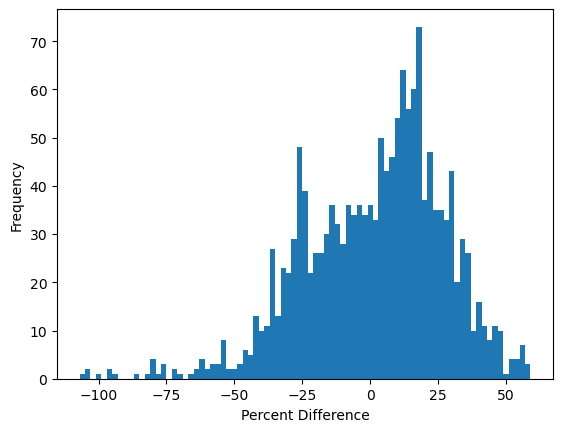

In [12]:
# Retrieve the percent difference data values and show in a histogram, ignoring NaN values.
# Some extra logic is required to automatically enforce bins of width 2%
import numpy as np
import matplotlib.pyplot as plt

pdiff_data = recon.PercentDiff()
data_min, data_max = np.floor(np.nanmin(pdiff_data)), np.ceil(np.nanmax(pdiff_data))
num_bins = int((data_max-data_min)/2.)
if num_bins<5:
    num_bins=20
hist, edges, patches = plt.hist(np.ravel(pdiff_data), range=(data_min,data_max),bins=num_bins)
plt.xlabel('Percent Difference')
plt.ylabel('Frequency')